In [1]:
import os
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [2]:
# save_root_dir = "testing_contrastive_results"
# save_root_dir = "testing_contrastive_distinct_init_train_long_results"
save_root_dir = "testing_contrastive_distinct_init_adapt_results"
# save_root_dir = "testing_contrastive_refactor_freezing_results"
# save_root_dir = "testing_contrastive_results_20epochs"
dataset = "mnist"
# algo = "monolithic"
algo = "modular"
seed = 0

In [3]:
experiment = os.path.join(save_root_dir, f"{dataset}_{algo}", dataset,algo, f"seed_{seed}")

In [4]:
config_path = os.path.join(experiment, "hydra_out", ".hydra", "config.yaml")
# read the config file
cfg = omegaconf.OmegaConf.load(config_path)
cfg

{'train': {'component_update_freq': 200, 'num_epochs': 200, 'save_freq': 1}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 6, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': False}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'freeze_encoder': True}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular', 'num_agents': 1, 'root_save_dir': 'testing_contrastive_distinct_init_adapt_results', 'parallel': False, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 64, 'improvement_threshold': 0.05}}

In [5]:
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg = setup_experiment(cfg)
len(datasets)

{'train': {'component_update_freq': 200, 'num_epochs': 200, 'save_freq': 1}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 6, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': False}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'freeze_encoder': True}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular', 'num_agents': 1, 'root_save_dir': 'testing_contrastive_distinct_init_adapt_results', 'parallel': False, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 64, 'improvement_threshold': 0.05}}
i_size 28
num_classes 10
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'freeze_encoder': True, 'i_size': 28, 'num_classes': 10, 'num_tasks': 6, 'num_init_tasks': 4}
<class 'shell.learners.er_dynamic.C

1

In [6]:
classes_sequence_list = [dataset.class_sequence for dataset in datasets]
classes_sequence_list

[array([5, 9, 7, 0, 1, 4, 6, 3, 8, 0, 1, 0])]

In [7]:
task_id = 5
net = load_net(cfg, NetCls, net_cfg, agent_id=0, task_id=task_id, num_added_components=1)
net

MLPSoftLLDynamic(
  (structure): ParameterList(
      (0): Parameter containing: [torch.float32 of size 5x4 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 5x4 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 5x4 (GPU 0)]
      (3): Parameter containing: [torch.float32 of size 5x4 (GPU 0)]
      (4): Parameter containing: [torch.float32 of size 5x4 (GPU 0)]
      (5): Parameter containing: [torch.float32 of size 5x4 (GPU 0)]
  )
  (softmax): Softmax(dim=0)
  (encoder): ModuleList(
    (0-5): 6 x Linear(in_features=784, out_features=64, bias=True)
  )
  (components): ModuleList(
    (0-4): 5 x Linear(in_features=64, out_features=64, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (decoder): ModuleList(
    (0-5): 6 x Linear(in_features=64, out_features=10, bias=True)
  )
)

In [10]:
task_id = 5
dataset = datasets[0]
testloaders = {task: torch.utils.data.DataLoader(testset,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         num_workers=0,
                                                         pin_memory=True,
                                                         ) for task, testset in enumerate(dataset.testset[:(task_id+1)])}

In [11]:
with torch.no_grad():
    for task_id, testloader in testloaders.items():
        correct = 0.
        n = 0.
        for X, y in testloader:
            X = X.to(net.device)
            y = y.to(net.device)
            Y_hat = net(X, task_id)
            correct += (Y_hat.argmax(dim=1) == y).sum().item()
            n += len(y)
        print(f"Task {task_id} accuracy: {correct/n}")

Task 0 accuracy: 0.9431877958968964
Task 1 accuracy: 0.9686254980079682
Task 2 accuracy: 0.9853566367501181
Task 3 accuracy: 0.9603658536585366
Task 4 accuracy: 0.977482088024565
Task 5 accuracy: 0.9872340425531915


In [12]:
X_out = [] # features
y_out = [] # global labels
y_task = [] # globallabel_task_id
with torch.no_grad():
    for task_id, testloader in testloaders.items():
        for X, y in testloader:
            X = X.to(net.device)
            X_encode = net.contrastive_embedding(X, task_id)
            X_out.append(X_encode.cpu())
            y_out.append(y.cpu())
            y_task.append(np.ones_like(y) * task_id)
X_encode = np.concatenate(X_out, axis=0)
Y = np.concatenate(y_out, axis=0)
y_task = np.concatenate(y_task, axis=0)

In [13]:
X_encode.shape

(12063, 64)

In [14]:
print(dataset.class_sequence)
print(np.unique(Y, return_counts=True))

[5 9 7 0 1 4 6 3 8 0 1 0]
(array([0, 1, 3, 4, 5, 6, 7, 8, 9]), array([2940, 2270, 1010,  982,  892,  958, 1028,  974, 1009]))


In [15]:
X_embedded = TSNE(n_components=2, random_state=0, init="pca", n_jobs=-1).fit_transform(X_encode)

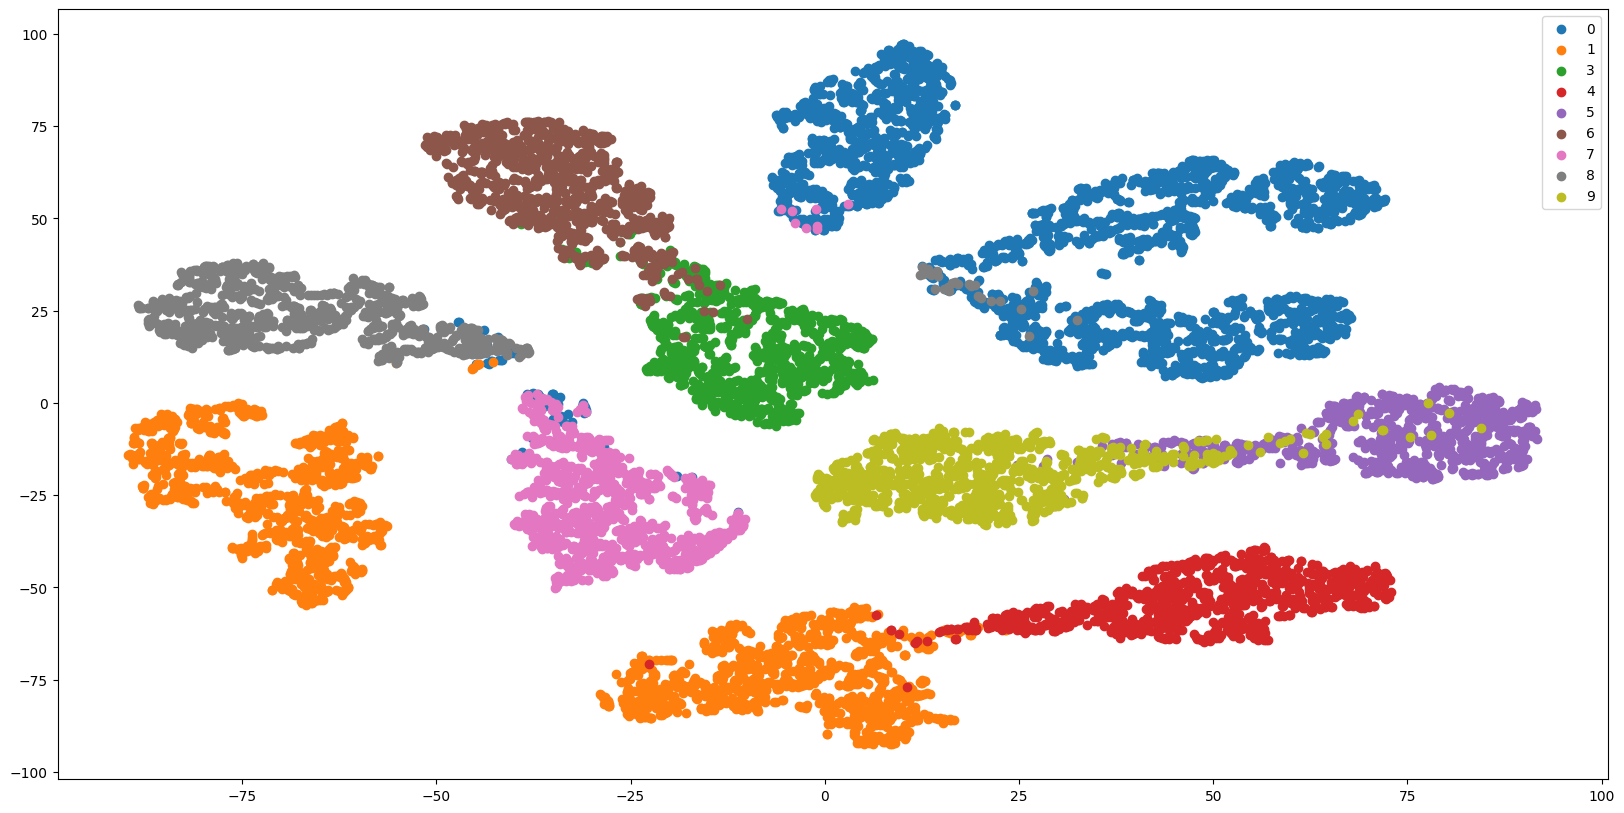

In [16]:
plt.figure(figsize=(20,10))

for y_label in np.unique(Y):
    plt.scatter(X_embedded[Y == y_label, 0], X_embedded[Y == y_label, 1], label=y_label)

plt.legend();

In [17]:
X_embedded.shape

(12063, 2)

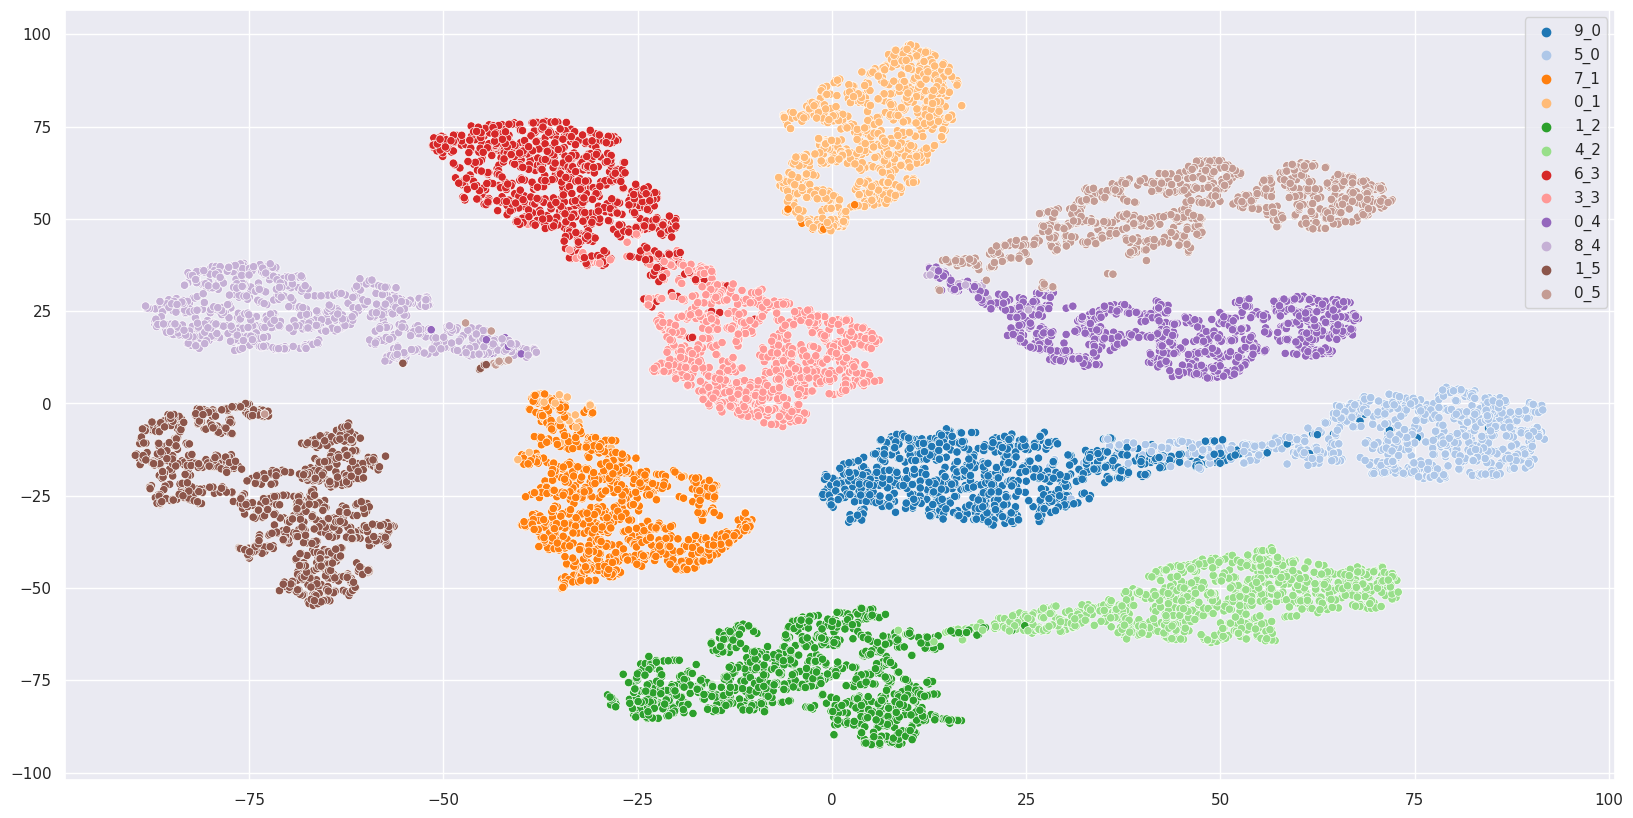

In [18]:
# create an array same size as y and y_task where each element is {y}_{y_task} string
y_task_str = np.array([str(Y[i]) + "_" + str(y_task[i]) for i in range(len(Y))])
# plot X_embedded with color corresponding to y_task_str
import seaborn as sns
# different sns color palette
# bigger plot size
sns.set(rc={'figure.figsize':(20,10)})
sns.set_palette("tab20")
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_task_str);